# Global Greening

## Installing & Importing Libraries

In [1]:
import pickle
import numpy as np
import pandas as pd
from PIL import Image
from patchify import patchify
import albumentations as A
from IPython.display import SVG
import graphviz
import matplotlib.pyplot as plt
%matplotlib inline
import os, re, sys, random, shutil, cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import applications, optimizers
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import model_to_dot, plot_model, image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger, LearningRateScheduler
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, ZeroPadding2D, Dropout

from sklearn.preprocessing import MinMaxScaler

/Users/Alenka/.pyenv/versions/3.10.6/envs/GlobalGreening/lib/python3.10/site-packages/tensorflow_io-0.32.0-py3.10-macosx-13.3-arm64.egg/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/Users/Alenka/.pyenv/versions/3.10.6/envs/GlobalGreening/lib/python3.10/site-packages/tensorflow_io-0.32.0-py3.10-macosx-13.3-arm64.egg/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ["[Errno 2] The file to load file system plugin from does not exist.: '/Users/Alenka/.pyenv/versions/3.10.6/envs/GlobalGreening/lib/python3.10/site-packages/tensorflow_io-0.32.0-py3.10-macosx-13.3-arm64.egg/tensorflow_io/python/ops/libtensorflow_io_plugins.so'"]
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/Users/Alenka/.pyenv/versions/3.10.6/envs/GlobalGreening/lib/python3.10/site-packages/tensorflow_io-0.32.0-py3.10-macosx-13.3-arm64.egg/tensorflow_io/python/ops/__init__

## Model information

[key link](https://github.com/kunnalparihar/Satellite-Image-Segmentation)

## Prepara Data Augmentation

**Augmentation using Albumentations Library**

[Albumentations](https://albumentations.ai/) is a Python library for fast and flexible image augmentations. Albumentations efficiently implements a rich variety of image transform operations that are optimized for performance, and does so while providing a concise, yet powerful image augmentation interface for different computer vision tasks, including object classification, segmentation, and detection.

Data augmentation is done by the following techniques:

1. Random Cropping - left out since we will have same size pictures
2. Horizontal Flipping
3. Vertical Flipping
4. Rotation
5. Random Brightness & Contrast
6. Contrast Limited Adaptive Histogram Equalization (CLAHE)
7. Grid Distortion
8. Optical Distortion

In [2]:
# # function to augment
# def augment(): #width, height
#     transform = A.Compose([
# #        A.RandomCrop(width=width, height=height, p=1.0),
#         A.HorizontalFlip(p=1.0),
#         A.VerticalFlip(p=1.0),
#         A.Rotate(limit=[60, 300], p=1.0, interpolation=cv2.INTER_NEAREST),
#         A.RandomBrightnessContrast(brightness_limit=[-0.2, 0.3], contrast_limit=0.2, p=1.0),
#         A.OneOf([
#             A.CLAHE (clip_limit=1.5, tile_grid_size=(8, 8), p=0.5),
#             A.GridDistortion(p=0.5),
#             A.OpticalDistortion(distort_limit=1, shift_limit=0.5, interpolation=cv2.INTER_NEAREST, p=0.5),
#         ], p=1.0),
#     ], p=1.0)
    
#     return transform

In [3]:
# # visualize the augmentations

# def visualize(image, mask, original_image=None, original_mask=None):
#     fontsize = 16

#     if original_image is None and original_mask is None:
#         f, ax = plt.subplots(2, 1, figsize=(10, 10)) 

#         ax[0].imshow(image)
#         ax[1].imshow(mask)
#     else:
#         f, ax = plt.subplots(2, 2, figsize=(16, 12))  

#         ax[0, 0].imshow(original_image)
#         ax[0, 0].set_title('Original Image', fontsize=fontsize)

#         ax[1, 0].imshow(original_mask)
#         ax[1, 0].set_title('Original Mask', fontsize=fontsize)

#         ax[0, 1].imshow(image)
#         ax[0, 1].set_title('Transformed Image', fontsize=fontsize)

#         ax[1, 1].imshow(mask)
#         ax[1, 1].set_title('Transformed Mask', fontsize=fontsize)
        
#     plt.savefig('sample_augmented_image.png', facecolor= 'w', transparent= False, bbox_inches= 'tight', dpi= 100)

## Loading the Data

In [4]:
# check where we are
!pwd

/Users/Alenka/code/Alastair908/GlobalGreening


In [5]:
# load the data
dataset_root_folder = '/Users/Alenka/code/Alastair908/GlobalGreening/raw_data'
dataset_name = 'images_trial_run'
mask_set_name = 'masks_trial_run'

In [6]:
# not used yet
load_batch_size=200

### Reading filenames 

In [7]:
# generating file names from the directory

images_dir = f'{dataset_root_folder}/{dataset_name}'
image_files = np.sort(os.listdir(images_dir))
# image_files = image_files[1:]
file_names = np.char.rstrip(image_files, '.png')
file_names = np.char.split(file_names, '_') 

In [8]:
images_dir

'/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run'

In [11]:
image_files[:3], len(image_files)

(array(['image0_-109.0_37.0.png', 'image100_-108.96_37.26.png',
        'image101_-108.96_37.3.png'], dtype='<U26'),
 681)

In [12]:
file_names[:3], len(file_names)

(array([list(['image0', '-109.0', '37.0']),
        list(['image100', '-108.96', '37.26']),
        list(['image101', '-108.96', '37.3'])], dtype=object),
 681)

In [13]:
# creating df with information about longitude, latitude (can also be used to load the images)
image_geo_locations = np.zeros((len(file_names),2))
image_geo_locations = pd.DataFrame(image_geo_locations, columns=['latitude', 'longitude'])

for image_type in ['latitude', 'longitude']:
    for i in range(len(file_names)):
        file = file_names[i]
        
        if image_type == 'latitude':
            text = file[0]
            image_number = ''.join(num for num in text if num.isdigit())
            latitude = file[1].strip('-') 
#            print(f'latitude is {latitude}')
            image_geo_locations.at[int(image_number),'latitude'] = latitude
                                   
        elif image_type == 'longitude':
            text = file[0]
            image_number = ''.join(num for num in text if num.isdigit())
            longitude = file[2] 
#            print(f'longitude is {longitude}')
            image_geo_locations.at[int(image_number),'longitude'] = longitude                     

image_geo_locations

,latitude,longitude
0,109.0,37.0
1,109.0,37.04
2,109.0,37.09
3,109.0,37.13
4,109.0,37.17
...,...,...
676,108.7,37.77
677,108.7,37.81
678,108.7,37.85
679,108.7,37.9


In [14]:
# DF directly from Tim

lat1 = 37.
lat2 = 41.
lon1 = -102.
lon2 = -109.
longitudes = []
latitudes = []
for i in np.arange(lon2,lon1,0.0427):
    for j in np.arange(lat1,lat2,0.0427):
        longitudes.append(i)
        latitudes.append(j)
locations = pd.DataFrame({
    'longitude': longitudes,
    'latitude': latitudes
})
locations

,longitude,latitude
0,-109.0000,37.0000
1,-109.0000,37.0427
2,-109.0000,37.0854
3,-109.0000,37.1281
4,-109.0000,37.1708
...,...,...
15411,-102.0399,40.8003
15412,-102.0399,40.8430
15413,-102.0399,40.8857
15414,-102.0399,40.9284


In [24]:
# testing out code for image file name
image_geo_locations.shape[0]
i=100
f'image{i}_-{image_geo_locations.iat[i,0]}_{image_geo_locations.iat[i,1]}.png'

'image100_-108.96_37.26.png'

In [15]:
# loading images into the list (new code so the files are loaded in correct order (by index))
images_dataset = []

for i in range(image_geo_locations.shape[0]):
    image_file =f'image{i}_-{image_geo_locations.iat[i,0]}_{image_geo_locations.iat[i,1]}.png'
    path_image = f'{dataset_root_folder}/{dataset_name}/{image_file}'
    print(path_image)
    image = Image.open(path_image)
    type(image)
    if np.array(image).shape[2] >3: 
        image = image.convert('RGB')
    image = np.asarray(image)
    images_dataset.append(image)
    print(f'appended image of size {image.shape}')

/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image0_-109.0_37.0.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image1_-109.0_37.04.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image2_-109.0_37.09.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image3_-109.0_37.13.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image4_-109.0_37.17.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image5_-109.0_37.21.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image6_-109.0_37.26.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_ru

appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image66_-109.0_39.82.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image67_-109.0_39.86.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image68_-109.0_39.9.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image69_-109.0_39.95.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image70_-109.0_39.99.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image71_-109.0_40.03.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image72_-109.0_40.07.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastai

appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image135_-108.96_38.75.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image136_-108.96_38.79.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image137_-108.96_38.84.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image138_-108.96_38.88.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image139_-108.96_38.92.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image140_-108.96_38.96.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image141_-108.96_39.01.png
appended image of size (512, 512, 3)
/Users/Alen

appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image204_-108.91_37.68.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image205_-108.91_37.73.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image206_-108.91_37.77.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image207_-108.91_37.81.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image208_-108.91_37.85.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image209_-108.91_37.9.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image210_-108.91_37.94.png
appended image of size (512, 512, 3)
/Users/Alenk

appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image273_-108.91_40.63.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image274_-108.91_40.67.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image275_-108.91_40.71.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image276_-108.91_40.76.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image277_-108.91_40.8.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image278_-108.91_40.84.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image279_-108.91_40.89.png
appended image of size (512, 512, 3)
/Users/Alenk

appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image342_-108.87_39.56.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image343_-108.87_39.6.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image344_-108.87_39.65.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image345_-108.87_39.69.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image346_-108.87_39.73.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image347_-108.87_39.78.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image348_-108.87_39.82.png
appended image of size (512, 512, 3)
/Users/Alenk

appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image411_-108.83_38.49.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image412_-108.83_38.54.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image413_-108.83_38.58.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image414_-108.83_38.62.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image415_-108.83_38.67.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image416_-108.83_38.71.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image417_-108.83_38.75.png
appended image of size (512, 512, 3)
/Users/Alen

appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image482_-108.79_37.51.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image483_-108.79_37.56.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image484_-108.79_37.6.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image485_-108.79_37.64.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image486_-108.79_37.68.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image487_-108.79_37.73.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image488_-108.79_37.77.png
appended image of size (512, 512, 3)
/Users/Alenk

appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image550_-108.79_40.42.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image551_-108.79_40.46.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image552_-108.79_40.5.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image553_-108.79_40.54.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image554_-108.79_40.59.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image555_-108.79_40.63.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image556_-108.79_40.67.png
appended image of size (512, 512, 3)
/Users/Alenk

appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image619_-108.74_39.35.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image620_-108.74_39.39.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image621_-108.74_39.43.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image622_-108.74_39.48.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image623_-108.74_39.52.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image624_-108.74_39.56.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image625_-108.74_39.6.png
appended image of size (512, 512, 3)
/Users/Alenk

In [15]:
# # loading images into the list
# images_dataset = []

# for file in image_files:
#     path_image = f'{dataset_root_folder}/{dataset_name}/{file}'
#     print(path_image)
#     image = Image.open(path_image)
#     type(image)
#     if np.array(image).shape[2] >3: 
#         image = image.convert('RGB')
#     images_dataset.append(np.array(image))
#     print(f'appended image of size {np.array(image).shape}')

/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image0_-109.0_37.0.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image100_-108.96_37.26.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image101_-108.96_37.3.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image102_-108.96_37.34.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image103_-108.96_37.38.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image104_-108.96_37.43.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image105_-108.96_37.47.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_dat

appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image156_-108.96_39.65.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image157_-108.96_39.69.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image158_-108.96_39.73.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image159_-108.96_39.78.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image15_-109.0_37.64.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image160_-108.96_39.82.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image161_-108.96_39.86.png
appended image of size (512, 512, 3)
/Users/Alenka

appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image210_-108.91_37.94.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image211_-108.91_37.98.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image212_-108.91_38.02.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image213_-108.91_38.07.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image214_-108.91_38.11.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image215_-108.91_38.15.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image216_-108.91_38.2.png
appended image of size (512, 512, 3)
/Users/Alenk

appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image277_-108.91_40.8.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image278_-108.91_40.84.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image279_-108.91_40.89.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image27_-109.0_38.15.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image280_-108.91_40.93.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image281_-108.91_40.97.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image282_-108.87_37.0.png
appended image of size (512, 512, 3)
/Users/Alenka/c

appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image336_-108.87_39.31.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image337_-108.87_39.35.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image338_-108.87_39.39.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image339_-108.87_39.43.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image33_-109.0_38.41.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image340_-108.87_39.48.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image341_-108.87_39.52.png
appended image of size (512, 512, 3)
/Users/Alenka

appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image391_-108.83_37.64.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image392_-108.83_37.68.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image393_-108.83_37.73.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image394_-108.83_37.77.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image395_-108.83_37.81.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image396_-108.83_37.85.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image397_-108.83_37.9.png
appended image of size (512, 512, 3)
/Users/Alenk

appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image459_-108.83_40.54.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image45_-109.0_38.92.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image460_-108.83_40.59.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image461_-108.83_40.63.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image462_-108.83_40.67.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image463_-108.83_40.71.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image464_-108.83_40.76.png
appended image of size (512, 512, 3)
/Users/Alenka

appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image520_-108.79_39.14.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image521_-108.79_39.18.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image522_-108.79_39.22.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image523_-108.79_39.26.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image524_-108.79_39.31.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image525_-108.79_39.35.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image526_-108.79_39.39.png
appended image of size (512, 512, 3)
/Users/Alen

appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image588_-108.74_38.02.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image589_-108.74_38.07.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image58_-109.0_39.48.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image590_-108.74_38.11.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image591_-108.74_38.15.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image592_-108.74_38.2.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image593_-108.74_38.24.png
appended image of size (512, 512, 3)
/Users/Alenka/

appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image649_-108.74_40.63.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image64_-109.0_39.73.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image650_-108.74_40.67.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image651_-108.74_40.71.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image652_-108.74_40.76.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image653_-108.74_40.8.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image654_-108.74_40.84.png
appended image of size (512, 512, 3)
/Users/Alenka/

appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image92_-109.0_40.93.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image93_-109.0_40.97.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image94_-108.96_37.0.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image95_-108.96_37.04.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image96_-108.96_37.09.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image97_-108.96_37.13.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image98_-108.96_37.17.png
appended image of size (512, 512, 3)
/Users/Alenka/code/Al

#### Investigating image RGBA problem

In [ ]:
path = '/Users/Alenka/OneDrive/GlobalGreening/zoomed_photos_model_test/image200_-108.91_37.51.png'
image = Image.open(path)
print(image.mode)
np.asarray(image)

In [ ]:
image2 = image.convert('RGB')
print(image2.mode)
np.asarray(image2)

In [ ]:
plt.imshow(image)

In [ ]:
plt.imshow(image2)

#### Back to loading and preprocessing

In [16]:
len(images_dataset), images_dataset[0].shape, type(images_dataset[0]), type(images_dataset)

(681, (512, 512, 3), numpy.ndarray, list)

In [17]:
masks_dir = f'{dataset_root_folder}/{mask_set_name}'
masks_files = np.sort(os.listdir(masks_dir)) 
masks_files

array(['land_use_data_from_0_to_680.npy'], dtype='<U31')

In [18]:
path_np_masks = f'{dataset_root_folder}/{mask_set_name}/{masks_files[0]}'
masks_dataset = np.load(path_np_masks)

In [19]:
masks_dataset.shape

(681, 512, 512, 3)

In [ ]:
# # to be used later when we load more than one numpy array of masks
# masks_dataset = []

# mask_files = np.sort(os.listdir(images_dir)) 

# for i in range(len(mask_files)):
#     path_np_masks = f'{dataset_root_folder}/{mask_set_name}/{mask_files[i]}'
#     f'mask_{i}' = np.load(path_np_masks)   

In [20]:
len(images_dataset), len(masks_dataset)

(681, 681)

In [21]:
image = images_dataset[0] 
mask = masks_dataset[0] 

print(image.shape, mask.shape, type(image))

(512, 512, 3) (512, 512, 3) <class 'numpy.ndarray'>


In [22]:
image_sizes = []

for i in range(len(images_dataset)):
    image_sizes.append(images_dataset[i].shape)

min(image_sizes), max(image_sizes)
min(image_sizes), max(image_sizes)

((512, 512, 3), (512, 512, 3))

In [23]:
mask_sizes = []

for i in range(len(masks_dataset)):
    mask_sizes.append(masks_dataset[i].shape)

min(mask_sizes), max(mask_sizes)

((512, 512, 3), (512, 512, 3))

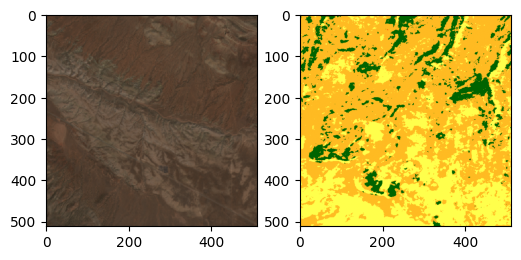

In [25]:
i = 500 
f, ax = plt.subplots(1, 2, figsize=(6, 6)) 
ax[0].imshow(images_dataset[i])
ax[1].imshow(masks_dataset[i])

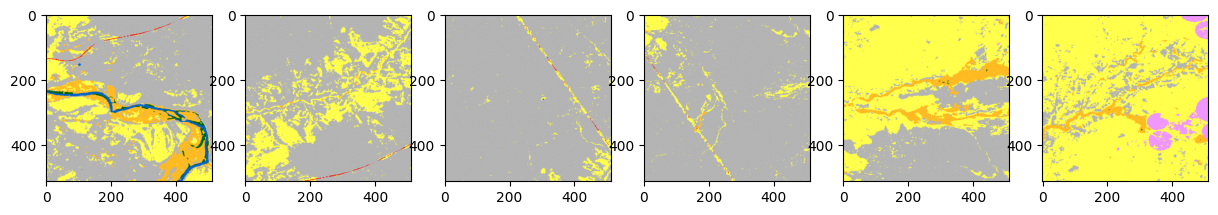

In [26]:
i = 0

f, ax = plt.subplots(1, 6, figsize=(15, 6)) 

ax[0].imshow(masks_dataset[i])
ax[1].imshow(masks_dataset[i+1])
ax[2].imshow(masks_dataset[i+2])
ax[3].imshow(masks_dataset[i+3])
ax[4].imshow(masks_dataset[i+4])
ax[5].imshow(masks_dataset[i+5])

In [ ]:
# visualize(image, mask)

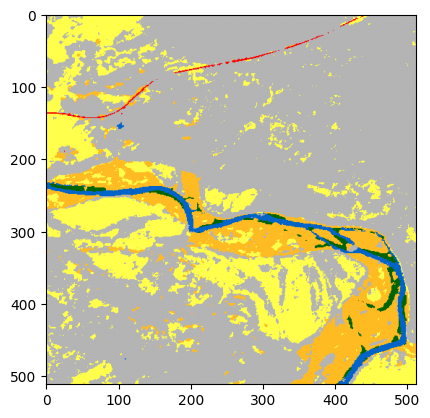

In [29]:
mask = masks_dataset[0]
plt.imshow(mask)

### Not used right not - option with Tf Dataset

In [ ]:
# # how are files loaded into Dataset

# file_names_unsorted = os.listdir(images_dir)
# print(len(file_names_unsorted))
# file_names_unsorted

# image_file_names = os.walk(f'{dataset_root_folder}/{dataset_name}')
# for image in image_file_names:
#     print(image)

In [ ]:
# images_tf_dataset = image_dataset_from_directory(
#     directory = f'{dataset_root_folder}/{dataset_name}',
#     labels=None,
#     color_mode='rgb',
#     batch_size=200,
#     image_size=(512, 512),
#     shuffle=True,
#     seed=1)

In [ ]:
# # get_single_element randomly chooses an element

# plt.imshow(images_tf_dataset.get_single_element()[0]/255)

## Image masks

The images are densely labeled and contain the following 6 classes:

| Name       | R   | G   | B   | Color                                                                                              |
| ---------- | --- | --- | --- | -------------------------------------------------------------------------------------------------- |
| Building   | 60  | 16  | 152 | <p align="center"><div style="background-color: rgb(60, 16, 152); padding: 10px; "/></p>   |
| Land       | 132 | 41  | 246 | <p align="center"><div style="background-color: rgb(132, 41, 246); padding: 10px; "/></p>   |
| Road       | 110 | 193 | 228 | <p align="center"><div style="background-color: rgb(110, 193, 228); padding: 10px; "/></p>   |
| Vegetation | 254 | 221 | 58  | <p align="center"><div style="background-color: rgb(254, 221, 58); padding: 10px; "/></p>   |
| Water      | 226 | 169 | 41  | <p align="center"><div style="background-color: rgb(226, 169, 41); padding: 10px; "/></p>   |
| Unlabeled  | 155 | 155 | 155 | <p align="center"><div style="background-color: rgb(155, 155, 155); padding: 10px; "/></p>   |


Value	Color	Description
- 10	#006400	Tree cover 
<p align="center"><div style="background-color: #006400; padding: 10px; "/></p>   
- 20	#ffbb22	Shrubland 
<p align="center"><div style="background-color: #ffbb22; padding: 10px; "/></p>   
- 30	#ffff4c	Grassland
<p align="center"><div style="background-color: #ffff4c; padding: 10px; "/></p>   
- 40	#f096ff	Cropland
<p align="center"><div style="background-color: #f096ff; padding: 10px; "/></p>  
- 50	#fa0000	Built-up
<p align="center"><div style="background-color: #fa0000; padding: 10px; "/></p>  
- 60	#b4b4b4	Bare / sparse vegetation
<p align="center"><div style="background-color: #b4b4b4; padding: 10px; "/></p>  
- 70	#f0f0f0	Snow and ice
<p align="center"><div style="background-color: #f0f0f0; padding: 10px; "/></p>  
- 80	#0064c8	Permanent water bodies
<p align="center"><div style="background-color: #0064c8; padding: 10px; "/></p>  
- 90	#0096a0	Herbaceous wetland
<p align="center"><div style="background-color: #0096a0; padding: 10px; "/></p>  
- 95	#00cf75	Mangroves
<p align="center"><div style="background-color: #00cf75; padding: 10px; "/></p>  
- 100	#fae6a0	Moss and lichen
<p align="center"><div style="background-color: #fae6a0; padding: 10px; "/></p>  

## Perform Augmentation

In [ ]:
transform = augment()
transformed = transform(image=image, mask=mask)
transformed_image = transformed['image']
transformed_mask = transformed['mask']

visualize(transformed_image, transformed_mask, image, mask)

In [ ]:
def augment_dataset(count):
    '''Function for data augmentation
        Input:
            count - total no. of images after augmentation = initial no. of images * count
        Output:
            writes augmented images (input images & segmentation masks) to the working directory
    '''
    transform = augment() 
    aug_images_dataset = []
    aug_masks_dataset = []
    
    i = 0
    for i in range(count):
        for j in range(len(images_dataset)):
            img = images_dataset[j]
            msk = masks_dataset[j] 
            
            transformed = transform(image=img, mask=msk)
            transformed_image = transformed['image']
            transformed_mask = transformed['mask'] 
       
            aug_images_dataset.append(transformed_image)
            aug_masks_dataset.append(transformed_mask)
    return aug_images_dataset, aug_masks_dataset 

In [ ]:
aug_images_dataset, aug_masks_dataset  = augment_dataset(8)

In [ ]:
len(images_dataset), len(masks_dataset), len(aug_images_dataset), len(aug_masks_dataset)

In [ ]:
image_sizes = []

for i in range(len(images_dataset)):
    image_sizes.append(images_dataset[i].shape)

min(image_sizes), max(image_sizes)

In [ ]:
mask_sizes = []

for i in range(len(masks_dataset)):
    mask_sizes.append(masks_dataset[i].shape)

min(mask_sizes), max(mask_sizes)

In [ ]:
# show first 3 augmented images + masks for first image 

f, ax = plt.subplots(2, 4, figsize=(12, 6)) 

ax[0,0].imshow(images_dataset[0])
ax[0,1].imshow(masks_dataset[0])

ax[0,2].imshow(aug_images_dataset[0])
ax[0,3].imshow(aug_masks_dataset[0])

ax[1,0].imshow(aug_images_dataset[72])
ax[1,1].imshow(aug_masks_dataset[72])

ax[1,2].imshow(aug_images_dataset[144])
ax[1,3].imshow(aug_masks_dataset[144])


## Preparing labels

In [30]:
labels_dict = {"classes": [
{"title": "Tree cover", "r": 0 , "g": 0 , "b": 0 }, 
{"title": "Shrubland", "r": 132, "g": 41, "b": 246 }, 
{"title": "Grassland", "r": 110, "g": 193, "b": 228 }, 
{"title": "Cropland", "r": 60, "g": 16, "b": 152 }, 
{"title": "Built-up", "r": 254, "g": 221, "b": 58 }, 
{"title": "Bare, sparse vegetation", "r": 155, "g": 155, "b": 155 },
{"title": "Snow and ice", "r": 155, "g": 155, "b": 155 },
{"title": "Permanent water bodies", "r": 155, "g": 155, "b": 155 },
{"title": "Herbaceous wetland", "r": 155, "g": 155, "b": 155 },
{"title": "Mangroves", "r": 155, "g": 155, "b": 155 },
{"title": "Moss and lichen", "r": 155, "g": 155, "b": 155 }
]}

labels_dict_df = pd.DataFrame(labels_dict['classes'])
labels_dict_df

,title,r,g,b
0,Tree cover,0,0,0
1,Shrubland,132,41,246
2,Grassland,110,193,228
3,Cropland,60,16,152
4,Built-up,254,221,58
5,"Bare, sparse vegetation",155,155,155
6,Snow and ice,155,155,155
7,Permanent water bodies,155,155,155
8,Herbaceous wetland,155,155,155
9,Mangroves,155,155,155


In [31]:
hex_colors_list = ['#006400', '#ffbb22', '#ffff4c', '#f096ff', '#fa0000',
                   '#b4b4b4', '#f0f0f0', '#0064c8', '#0096a0', '#00cf75', '#fae6a0']

for i in range(len(hex_colors_list)):
    color = hex_colors_list[i].lstrip('#')
    r = int(color[0:2],16)
    g = int(color[2:4],16)
    b = int(color[4:6],16)
    labels_dict_df.at[i,'r'] = r
    labels_dict_df.at[i,'g'] = g
    labels_dict_df.at[i,'b'] = b

In [32]:
labels_dict_df

,title,r,g,b
0,Tree cover,0,100,0
1,Shrubland,255,187,34
2,Grassland,255,255,76
3,Cropland,240,150,255
4,Built-up,250,0,0
5,"Bare, sparse vegetation",180,180,180
6,Snow and ice,240,240,240
7,Permanent water bodies,0,100,200
8,Herbaceous wetland,0,150,160
9,Mangroves,0,207,117


In [33]:
label_names= list(labels_dict_df.title)
label_codes = []
r= np.asarray(labels_dict_df.r)
g= np.asarray(labels_dict_df.g)
b= np.asarray(labels_dict_df.b)

for i in range(len(labels_dict_df)):
    label_codes.append(tuple([r[i], g[i], b[i]]))
    
label_codes, label_names

([(0, 100, 0),
  (255, 187, 34),
  (255, 255, 76),
  (240, 150, 255),
  (250, 0, 0),
  (180, 180, 180),
  (240, 240, 240),
  (0, 100, 200),
  (0, 150, 160),
  (0, 207, 117),
  (250, 230, 160)],
 ['Tree cover',
  'Shrubland',
  'Grassland',
  'Cropland',
  'Built-up',
  'Bare, sparse vegetation',
  'Snow and ice',
  'Permanent water bodies',
  'Herbaceous wetland',
  'Mangroves',
  'Moss and lichen'])

In [34]:
code2id = {v:k for k,v in enumerate(label_codes)}
id2code = {k:v for k,v in enumerate(label_codes)}

name2id = {v:k for k,v in enumerate(label_names)}
id2name = {k:v for k,v in enumerate(label_names)}

In [35]:
id2code

{0: (0, 100, 0),
 1: (255, 187, 34),
 2: (255, 255, 76),
 3: (240, 150, 255),
 4: (250, 0, 0),
 5: (180, 180, 180),
 6: (240, 240, 240),
 7: (0, 100, 200),
 8: (0, 150, 160),
 9: (0, 207, 117),
 10: (250, 230, 160)}

In [36]:
id2name

{0: 'Tree cover',
 1: 'Shrubland',
 2: 'Grassland',
 3: 'Cropland',
 4: 'Built-up',
 5: 'Bare, sparse vegetation',
 6: 'Snow and ice',
 7: 'Permanent water bodies',
 8: 'Herbaceous wetland',
 9: 'Mangroves',
 10: 'Moss and lichen'}

## Function to One-hot Encode RGB Labels/Masks and Decoding Encoded Predictions

In [37]:
def rgb_to_onehot(rgb_mask_image, colormap = id2code):
    '''Function to one hot encode RGB mask labels
        Inputs: 
            rgb_image - image matrix (eg. 256 x 256 x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    num_classes = len(colormap)
    # shape prepared for image size and channels = num of classes (instead of 3 RGB colors)
    shape = rgb_mask_image.shape[:2]+(num_classes,)
    # encoded_image prepare array with right shaoe 
    encoded_mask = np.zeros( shape, dtype=np.int8 )
    for i, cls in enumerate(colormap):
        # image.reshape flattens and keeps 3 channels, 
        # then checks which pixels same as color in colormap
        # then change back to image size for each of 6 channels (based on colormap)
        encoded_mask[:,:,i] = np.all(rgb_mask_image.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])

    return encoded_mask

In [38]:
def onehot_to_rgb(onehot, colormap = id2code):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.uint8(output)

mask shape is RGB image (512, 512, 3)
encoded mask is 6 channel array (512, 512, 11)


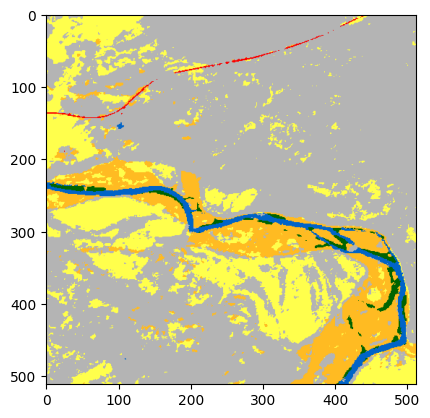

In [40]:
# checking that it works
mask = masks_dataset[0]
print(f'mask shape is RGB image {mask.shape}')
encoded_mask = rgb_to_onehot(mask*255, colormap = id2code)
decoded_mask = onehot_to_rgb(encoded_mask, colormap = id2code)
plt.imshow(decoded_mask);
print(f'encoded mask is 6 channel array {encoded_mask.shape}')

#### **Input on loading and preprocessing Images**

Deprecated: tf.keras.preprocessing.image.ImageDataGenerator is not recommended for new code. Prefer loading images with tf.keras.utils.image_dataset_from_directory and transforming the output tf.data.Dataset with preprocessing layers. For more information, see the tutorials for loading images and augmenting images, as well as the preprocessing layer guide.


we will use function [`tf.keras.utils.image_dataset_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)

and resize with [keras.layers.resizing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Resizing)

In [ ]:
# not yet used

# image_dataset_from_directory(
#     directory,
#     labels='inferred',
#     label_mode='int',
#     class_names=None,
#     color_mode='rgb',
#     batch_size=32,
#     image_size=(256, 256),
#     shuffle=True,
#     seed=None,
#     validation_split=None,
#     subset=None,
#     interpolation='bilinear',
#     follow_links=False,
#     crop_to_aspect_ratio=False,
#     **kwargs
# )

## Model

In [45]:
type(masks_dataset)

numpy.ndarray

In [51]:
masks_dataset

array([[[[0.70588235, 0.70588235, 0.70588235],
         [0.70588235, 0.70588235, 0.70588235],
         [0.70588235, 0.70588235, 0.70588235],
         ...,
         [0.70588235, 0.70588235, 0.70588235],
         [0.70588235, 0.70588235, 0.70588235],
         [0.70588235, 0.70588235, 0.70588235]],

        [[0.70588235, 0.70588235, 0.70588235],
         [0.70588235, 0.70588235, 0.70588235],
         [0.70588235, 0.70588235, 0.70588235],
         ...,
         [0.70588235, 0.70588235, 0.70588235],
         [0.70588235, 0.70588235, 0.70588235],
         [0.70588235, 0.70588235, 0.70588235]],

        [[0.70588235, 0.70588235, 0.70588235],
         [0.70588235, 0.70588235, 0.70588235],
         [0.70588235, 0.70588235, 0.70588235],
         ...,
         [0.70588235, 0.70588235, 0.70588235],
         [0.70588235, 0.70588235, 0.70588235],
         [0.70588235, 0.70588235, 0.70588235]],

        ...,

        [[0.70588235, 0.70588235, 0.70588235],
         [0.70588235, 0.70588235, 0.70588235]

In [52]:
masks_dataset_for_encoding = masks_dataset * 255
# encoded_masks = masks_dataset.map(rgb_to_onehot)

In [58]:
masks_dataset_for_encoding[100].shape

(512, 512, 3)

In [62]:
encoded_masks = []

for i in range(len(masks_dataset)): #len(masks_dataset)
    mask = masks_dataset[i]
    encoded_mask = rgb_to_onehot(mask*255, colormap = id2code)
    encoded_masks.append(encoded_mask)

In [65]:
type(encoded_masks), len(encoded_masks), encoded_masks[0].shape

(list, 681, (512, 512, 11))

In [66]:
y = np.array(encoded_masks) 
X = np.array(images_dataset)/255.
len(y), len(X)

(681, 681)

In [67]:
# Preparing X(images) and y(labels) - to be added to load images later

# Finally we shuffle:
p = np.random.permutation(len(X))
X, y = X[p], y[p]

# first split is for train/val data, second split for test data
split = int(len(X) /6.) 
X_test, X_train = X[:split], X[split:]
y_test, y_train = y[:split], y[split:] 

In [76]:
len(X_test), len(X_train), len(y_test), len(y_train)

(113, 568, 113, 568)

In [77]:
X_test.shape, X_train.shape, y_test.shape, y_train.shape

((113, 512, 512, 3),
 (568, 512, 512, 3),
 (113, 512, 512, 11),
 (568, 512, 512, 11))

### InceptionResNetV2 UNet

In [71]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_inception_resnetv2_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained InceptionResNetV2 Model """
    encoder = InceptionResNetV2(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = encoder.get_layer("input_1").output           ## (512 x 512)

    s2 = encoder.get_layer("activation").output        ## (255 x 255)
    s2 = ZeroPadding2D(( (1, 0), (1, 0) ))(s2)         ## (256 x 256)

    s3 = encoder.get_layer("activation_3").output      ## (126 x 126)
    s3 = ZeroPadding2D((1, 1))(s3)                     ## (128 x 128)

    s4 = encoder.get_layer("activation_74").output      ## (61 x 61)
    s4 = ZeroPadding2D(( (2, 1),(2, 1) ))(s4)           ## (64 x 64)

    """ Bridge """
    b1 = encoder.get_layer("activation_161").output     ## (30 x 30)
    b1 = ZeroPadding2D((1, 1))(b1)                      ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)
    
    """ Output """
    dropout = Dropout(0.3)(d4)
    outputs = Conv2D(11, 1, padding="same", activation="softmax")(dropout)

    model = Model(inputs, outputs, name="InceptionResNetV2-UNet")
    return model

In [72]:
K.clear_session()

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

model = build_inception_resnetv2_unet(input_shape = (512, 512, 3))
model.compile(optimizer=Adam(lr = 0.0001), loss='categorical_crossentropy', metrics=[dice_coef, "accuracy"])
model.summary()

Model: "InceptionResNetV2-UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 255, 255, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 255, 255, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                            

                                                                                                  
 conv2d_10 (Conv2D)             (None, 61, 61, 96)   82944       ['activation_9[0][0]']           
                                                                                                  
 conv2d_11 (Conv2D)             (None, 61, 61, 64)   12288       ['average_pooling2d[0][0]']      
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 61, 61, 96)  288         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 61, 61, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
          

 conv2d_21 (Conv2D)             (None, 61, 61, 32)   10240       ['block35_1_ac[0][0]']           
                                                                                                  
 batch_normalization_21 (BatchN  (None, 61, 61, 32)  96          ['conv2d_21[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_21 (Activation)     (None, 61, 61, 32)   0           ['batch_normalization_21[0][0]'] 
                                                                                                  
 conv2d_19 (Conv2D)             (None, 61, 61, 32)   10240       ['block35_1_ac[0][0]']           
                                                                                                  
 conv2d_22 (Conv2D)             (None, 61, 61, 48)   13824       ['activation_21[0][0]']          
          

 batch_normalization_26 (BatchN  (None, 61, 61, 32)  96          ['conv2d_26[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_29 (BatchN  (None, 61, 61, 64)  192         ['conv2d_29[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_24 (Activation)     (None, 61, 61, 32)   0           ['batch_normalization_24[0][0]'] 
                                                                                                  
 activation_26 (Activation)     (None, 61, 61, 32)   0           ['batch_normalization_26[0][0]'] 
                                                                                                  
 activatio

 conv2d_37 (Conv2D)             (None, 61, 61, 32)   10240       ['block35_4_ac[0][0]']           
                                                                                                  
 conv2d_40 (Conv2D)             (None, 61, 61, 48)   13824       ['activation_39[0][0]']          
                                                                                                  
 batch_normalization_37 (BatchN  (None, 61, 61, 32)  96          ['conv2d_37[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_40 (BatchN  (None, 61, 61, 48)  144         ['conv2d_40[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 activation_44 (Activation)     (None, 61, 61, 32)   0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 activation_47 (Activation)     (None, 61, 61, 64)   0           ['batch_normalization_47[0][0]'] 
                                                                                                  
 block35_6_mixed (Concatenate)  (None, 61, 61, 128)  0           ['activation_42[0][0]',          
                                                                  'activation_44[0][0]',          
                                                                  'activation_47[0][0]']          
                                                                                                  
 block35_6_conv (Conv2D)        (None, 61, 61, 320)  41280       ['block35_6_mixed[0][0]']        
          

 batch_normalization_58 (BatchN  (None, 61, 61, 48)  144         ['conv2d_58[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 61, 61, 32)   0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 activation_58 (Activation)     (None, 61, 61, 48)   0           ['batch_normalization_58[0][0]'] 
                                                                                                  
 conv2d_54 (Conv2D)             (None, 61, 61, 32)   10240       ['block35_7_ac[0][0]']           
                                                                                                  
 conv2d_56 (Conv2D)             (None, 61, 61, 32)   9216        ['activation_55[0][0]']          
          

                                                                  'activation_65[0][0]']          
                                                                                                  
 block35_9_conv (Conv2D)        (None, 61, 61, 320)  41280       ['block35_9_mixed[0][0]']        
                                                                                                  
 custom_scale_layer_8 (CustomSc  (None, 61, 61, 320)  0          ['block35_8_ac[0][0]',           
 aleLayer)                                                        'block35_9_conv[0][0]']         
                                                                                                  
 block35_9_ac (Activation)      (None, 61, 61, 320)  0           ['custom_scale_layer_8[0][0]']   
                                                                                                  
 conv2d_69 (Conv2D)             (None, 61, 61, 32)   10240       ['block35_9_ac[0][0]']           
          

 batch_normalization_75 (BatchN  (None, 30, 30, 384)  1152       ['conv2d_75[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_72 (Activation)     (None, 30, 30, 384)  0           ['batch_normalization_72[0][0]'] 
                                                                                                  
 activation_75 (Activation)     (None, 30, 30, 384)  0           ['batch_normalization_75[0][0]'] 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 30, 30, 320)  0          ['block35_10_ac[0][0]']          
                                                                                                  
 mixed_6a (Concatenate)         (None, 30, 30, 1088  0           ['activation_72[0][0]',          
          

                                                                                                  
 block17_2_conv (Conv2D)        (None, 30, 30, 1088  418880      ['block17_2_mixed[0][0]']        
                                )                                                                 
                                                                                                  
 custom_scale_layer_11 (CustomS  (None, 30, 30, 1088  0          ['block17_1_ac[0][0]',           
 caleLayer)                     )                                 'block17_2_conv[0][0]']         
                                                                                                  
 block17_2_ac (Activation)      (None, 30, 30, 1088  0           ['custom_scale_layer_11[0][0]']  
                                )                                                                 
                                                                                                  
 conv2d_85

                                                                                                  
 custom_scale_layer_13 (CustomS  (None, 30, 30, 1088  0          ['block17_3_ac[0][0]',           
 caleLayer)                     )                                 'block17_4_conv[0][0]']         
                                                                                                  
 block17_4_ac (Activation)      (None, 30, 30, 1088  0           ['custom_scale_layer_13[0][0]']  
                                )                                                                 
                                                                                                  
 conv2d_93 (Conv2D)             (None, 30, 30, 128)  139264      ['block17_4_ac[0][0]']           
                                                                                                  
 batch_normalization_93 (BatchN  (None, 30, 30, 128)  384        ['conv2d_93[0][0]']              
 ormalizat

                                                                                                  
 block17_6_ac (Activation)      (None, 30, 30, 1088  0           ['custom_scale_layer_15[0][0]']  
                                )                                                                 
                                                                                                  
 conv2d_101 (Conv2D)            (None, 30, 30, 128)  139264      ['block17_6_ac[0][0]']           
                                                                                                  
 batch_normalization_101 (Batch  (None, 30, 30, 128)  384        ['conv2d_101[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_101 (Activation)    (None, 30, 30, 128)  0           ['batch_normalization_101[0][0]']
          

                                                                                                  
 conv2d_109 (Conv2D)            (None, 30, 30, 128)  139264      ['block17_8_ac[0][0]']           
                                                                                                  
 batch_normalization_109 (Batch  (None, 30, 30, 128)  384        ['conv2d_109[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_109 (Activation)    (None, 30, 30, 128)  0           ['batch_normalization_109[0][0]']
                                                                                                  
 conv2d_110 (Conv2D)            (None, 30, 30, 160)  143360      ['activation_109[0][0]']         
                                                                                                  
 batch_nor

 batch_normalization_117 (Batch  (None, 30, 30, 128)  384        ['conv2d_117[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_117 (Activation)    (None, 30, 30, 128)  0           ['batch_normalization_117[0][0]']
                                                                                                  
 conv2d_118 (Conv2D)            (None, 30, 30, 160)  143360      ['activation_117[0][0]']         
                                                                                                  
 batch_normalization_118 (Batch  (None, 30, 30, 160)  480        ['conv2d_118[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 activation_125 (Activation)    (None, 30, 30, 128)  0           ['batch_normalization_125[0][0]']
                                                                                                  
 conv2d_126 (Conv2D)            (None, 30, 30, 160)  143360      ['activation_125[0][0]']         
                                                                                                  
 batch_normalization_126 (Batch  (None, 30, 30, 160)  480        ['conv2d_126[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_126 (Activation)    (None, 30, 30, 160)  0           ['batch_normalization_126[0][0]']
                                                                                                  
 conv2d_124 (Conv2D)            (None, 30, 30, 192)  208896      ['block17_12_ac[0][0]']          
          

                                                                                                  
 batch_normalization_134 (Batch  (None, 30, 30, 160)  480        ['conv2d_134[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_134 (Activation)    (None, 30, 30, 160)  0           ['batch_normalization_134[0][0]']
                                                                                                  
 conv2d_132 (Conv2D)            (None, 30, 30, 192)  208896      ['block17_14_ac[0][0]']          
                                                                                                  
 conv2d_135 (Conv2D)            (None, 30, 30, 192)  215040      ['activation_134[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 activation_142 (Activation)    (None, 30, 30, 160)  0           ['batch_normalization_142[0][0]']
                                                                                                  
 conv2d_140 (Conv2D)            (None, 30, 30, 192)  208896      ['block17_16_ac[0][0]']          
                                                                                                  
 conv2d_143 (Conv2D)            (None, 30, 30, 192)  215040      ['activation_142[0][0]']         
                                                                                                  
 batch_normalization_140 (Batch  (None, 30, 30, 192)  576        ['conv2d_140[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

 conv2d_148 (Conv2D)            (None, 30, 30, 192)  208896      ['block17_18_ac[0][0]']          
                                                                                                  
 conv2d_151 (Conv2D)            (None, 30, 30, 192)  215040      ['activation_150[0][0]']         
                                                                                                  
 batch_normalization_148 (Batch  (None, 30, 30, 192)  576        ['conv2d_148[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_151 (Batch  (None, 30, 30, 192)  576        ['conv2d_151[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 conv2d_transpose (Conv2DTransp  (None, 64, 64, 512)  590336     ['zero_padding2d_3[0][0]']       
 ose)                                                                                             
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 64, 64, 256)  0          ['activation_74[0][0]']          
 D)                                                                                               
                                                                                                  
 concatenate (Concatenate)      (None, 64, 64, 768)  0           ['conv2d_transpose[0][0]',       
                                                                  'zero_padding2d_2[0][0]']       
                                                                                                  
 conv2d_203 (Conv2D)            (None, 64, 64, 512)  3539456     ['concatenate[0][0]']            
          

 conv2d_209 (Conv2D)            (None, 512, 512, 64  38656       ['concatenate_3[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_209 (Batch  (None, 512, 512, 64  256        ['conv2d_209[0][0]']             
 Normalization)                 )                                                                 
                                                                                                  
 activation_209 (Activation)    (None, 512, 512, 64  0           ['batch_normalization_209[0][0]']
                                )                                                                 
                                                                                                  
 conv2d_210 (Conv2D)            (None, 512, 512, 64  36928       ['activation_209[0][0]']         
          

In [ ]:
# graph the model
SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, expand_nested=True)

### Modelling

In [74]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.0001, 60)

lr_scheduler = LearningRateScheduler(
    exponential_decay_fn,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath = 'Trial_InceptionResNetV2-UNet.h5',
    save_best_only = True, 
#     save_weights_only = False,
    monitor = 'val_loss', 
    mode = 'auto', 
    verbose = 1
)

earlystop = EarlyStopping(
    monitor = 'val_loss', 
    min_delta = 0.001, 
    patience = 12, 
    mode = 'auto', 
    verbose = 1,
    restore_best_weights = True
)

csvlogger = CSVLogger(
    filename= "Trial_model_training.csv",
    separator = ",",
    append = False
)

callbacks = [checkpoint, earlystop, csvlogger, lr_scheduler]

In [75]:
batch_size = 32

steps_per_epoch = np.ceil(float(len(X_train)*0.8) / float(batch_size))
print('steps_per_epoch: ', steps_per_epoch)

validation_steps = np.ceil(float(len(X_train)*0.2) / float(batch_size))
print('validation_steps: ', validation_steps)

steps_per_epoch:  15.0
validation_steps:  4.0


In [ ]:
history = model.fit(
    X_train_val, 
    y_train_val,
    batch_size=batch_size,
    validation_split = 0.2, 
    epochs = 50,
    callbacks=callbacks, 
    verbose=1
)

In [ ]:
df_result = pd.DataFrame(history.history)
df_result

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(40, 5))
ax = ax.ravel()
metrics = ['Dice Coefficient', 'Accuracy', 'Loss', 'Learning Rate']

for i, met in enumerate(['dice_coef', 'accuracy', 'loss', 'lr']): 
    if met != 'lr':
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('{} vs Epochs'.format(metrics[i]), fontsize=16)
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel(metrics[i])
        ax[i].set_xticks(np.arange(0,45,4))
        ax[i].legend(['Train', 'Validation'])
        ax[i].xaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
        ax[i].yaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
    else:
        ax[i].plot(history.history[met])
        ax[i].set_title('{} vs Epochs'.format(metrics[i]), fontsize=16)
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel(metrics[i])
        ax[i].set_xticks(np.arange(0,45,4))
        ax[i].xaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
        ax[i].yaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
        
plt.savefig('model_metrics_plot.png', facecolor= 'w',transparent= False, bbox_inches= 'tight', dpi= 150)

In [ ]:
model.load_weights("./Trial_InceptionResNetV2-UNet.h5")

In [ ]:
# need to change this
testing_gen = ValAugmentGenerator(val_images_dir = val_images, val_masks_dir = val_masks, target_size = (512, 512))

In [ ]:
count = 0
for i in range(2):
    batch_img,batch_mask = next(testing_gen)
    pred_all= model.predict(batch_img)
    np.shape(pred_all)
    
    for j in range(0,np.shape(pred_all)[0]):
        count += 1
        fig = plt.figure(figsize=(20,8))

        ax1 = fig.add_subplot(1,3,1)
        ax1.imshow(batch_img[j])
        ax1.set_title('Input Image', fontdict={'fontsize': 16, 'fontweight': 'medium'})
        ax1.grid(False)

        ax2 = fig.add_subplot(1,3,2)
        ax2.set_title('Ground Truth Mask', fontdict={'fontsize': 16, 'fontweight': 'medium'})
        ax2.imshow(onehot_to_rgb(batch_mask[j],id2code))
        ax2.grid(False)

        ax3 = fig.add_subplot(1,3,3)
        ax3.set_title('Predicted Mask', fontdict={'fontsize': 16, 'fontweight': 'medium'})
        ax3.imshow(onehot_to_rgb(pred_all[j],id2code))
        ax3.grid(False)

        plt.savefig('./predictions/prediction_{}.png'.format(count), facecolor= 'w', transparent= False, bbox_inches= 'tight', dpi= 200)
        plt.show()

### Sandbox

### This is code copied from the challenge 


````
X = np.array(imgs)
num_classes = len(set(labels))
y = to_categorical(labels, num_classes)

##### Finally we shuffle:
p = np.random.permutation(len(X))
X, y = X[p], y[p]

first_split = int(len(imgs) /6.)
second_split = first_split + int(len(imgs) * 0.2)
X_test, X_val, X_train = X[:first_split], X[first_split:second_split], X[second_split:]
y_test, y_val, y_train = y[:first_split], y[first_split:second_split], y[second_split:]
    
return X_train, y_train, X_val, y_val, X_test, y_test, num_classes
````

